In [1]:
import numpy as np
import pandas as pd
from my_gmd import speculator, asset_dynamics
from scipy.stats import norm
from scipy.optimize import fixed_point
import matplotlib.pyplot as plt
from warnings import warn
from typing import Optional
plt.style.use('bmh')

%load_ext autoreload
%autoreload 2

# Parameters

values

In [3]:
##Parameters: 

alpha = 0.5 ## prop of informed traders
eta = 0.5 ## prop of buy/sell orders from u_traders
tmax = 100 ## duration of simulation

## true value
V0 = 100 ## initial price
sigma_price = 0.5
proba_jump = 0.001
val = asset_dynamics(p_jump=proba_jump, sigma=sigma_price, init_price=V0)
val.simulate(tmax = tmax)
true_value = val.price(tmax = tmax).to_list()

## noisy informed traders
sigma_w = 0.05
nit_noise = np.random.normal(0, sigma_w, tmax)

## mm prior of true value distrib
## sigma_price already set above
## prior distrib is N(0, sig^2)

##tracking of bid and ask
bids=[] ## will both have lenght tmax in the end
asks=[]


Initial prior on V

# Bid and ask setting functions

predictor prior proba (Prior proba of sell order)

In [2]:
## Pr(sell) prior

def P_sell(Pb, alpha, eta, sigma_w, vec_v:Optional[list], v_prior:Optional[list], known_value:Optional[float]=None):
    '''
    This is the prior proba of a selling order arriving
    Args:
        - Pb: the bid price to solve (FP eq)
        - V_min: the min value of true value (min of vec_v)
        - V_max: the max value of true value (max of vec_v)
        - alpha: prob of informed traders
        - eta: proportion of buy/sell orders from uninformed traders
        - sigma_w: std of noise of noisy informed traders 
        - vec_v: vector of value Vi
        - v_prior: prior probability of V=Vi
    '''
    if (known_value is not None):
        assert known_value>0, "known value is negative, cannot compute P_sell"

        if known_value < Pb:
            result = alpha*norm.cdf(x=Pb-known_value, scale=sigma_w) + (1-alpha)*eta
        else:
            result = alpha*(1-norm.cdf(x=known_value-Pb, scale=sigma_w)) + (1-alpha)*eta

    else:

        #convert v into a df for usefulness
        prior_on_v = pd.DataFrame(data=[vec_v, v_prior]).T.rename(columns={0:"v", 1:"p"})

        ## first sum when Vi < Pb
        result = sum([(alpha*norm.cdf(x=Pb-Vi, scale=sigma_w) + (1-alpha)*eta)*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi < Pb])
        
        ## second sum when Vi >= Pb
        #result += sum([(alpha*(1-norm.cdf(x=Vi-Pb, scale=sigma_w)) + (1-alpha)*eta)*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi >= Pb])
        result +=  sum([(alpha*norm.cdf(x=Pb-Vi, scale=sigma_w) + (1-alpha)*eta)*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi >= Pb])

    assert (result>=0) and (result<=1), "P_sell is not between 0 and 1, problem"

    return result

    

define FP equation for bid price

In [3]:
def Pb_fp(Pb, alpha, eta, sigma_w, vec_v:Optional[list], v_prior:Optional[list], known_value:Optional[float]=None):
    '''
    This is the fixed point equation for the bid price Pb
    Args:
        - Pb: the bid price to solve (FP eq)
        - alpha: prob of informed traders
        - eta: proportion of buy/sell orders from uninformed traders
        - sigma_w: std of noise of noisy informed traders 
        - vec_v: vector of value Vi
        - v_prior: prior probability of V=Vi
    '''

    psell = P_sell(Pb=Pb, alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=v_prior, known_value=known_value)

    if known_value is not None:
        assert known_value > 0, "known value is negative, cannot compute P_sell"
        if known_value <= Pb:
            result = ((1-alpha)*eta + alpha*norm.cdf(x=Pb-known_value, scale=sigma_w))*known_value
        else:
            result = ((1-alpha)*eta + alpha*(1-norm.cdf(x=known_value-Pb, scale=sigma_w)))*known_value
            
    
    else:

        #convert v into a df for usefulness
        prior_on_v = pd.DataFrame(data=[vec_v, v_prior]).T.rename(columns={0:"v", 1:"p"})

        result = sum([((1-alpha)*eta + alpha*norm.cdf(x=Pb-Vi, scale=sigma_w))*Vi*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi <= Pb])

        #result += sum([((1-alpha)*eta + alpha*(1-norm.cdf(x=Vi-Pb, scale=sigma_w)))*Vi*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi > Pb])
        result += sum([((1-alpha)*eta + alpha*norm.cdf(x=Pb-Vi, scale=sigma_w))*Vi*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi > Pb])

    return result/psell

predictor prior proba (Prior proba of buy order)

In [4]:
def P_buy(Pa, alpha, eta, sigma_w, vec_v:Optional[list], v_prior:Optional[list], known_value:Optional[float]=None):
    '''
    This is the prior proba of a buying order arriving
    Args:
        - Pa: the ask price to solve (FP eq)
        - alpha: prob of informed traders
        - eta: proportion of buy/sell orders from uninformed traders
        - sigma_w: std of noise of noisy informed traders 
        - vec_v: vector of value Vi
        - v_prior: prior probability of V=Vi
    '''
    if (known_value is not None):
        assert known_value>0, "known value is negative, cannot compute P_buy"

        if known_value <= Pa:
            result = alpha*(1-norm.cdf(x=Pa-known_value, scale=sigma_w)) + (1-alpha)*eta
        else:
            result = alpha*norm.cdf(x=known_value-Pa, scale=sigma_w) + (1-alpha)*eta

    else:

        #convert v into a df for usefulness
        prior_on_v = pd.DataFrame(data=[vec_v, v_prior]).T.rename(columns={0:"v", 1:"p"})

        ## first sum when Vi < Pa
        #result = sum([(alpha*(1-norm.cdf(x=Pa-Vi, scale=sigma_w)) + (1-alpha)*eta)*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi <= Pa])
        result = sum([(alpha*(1-norm.cdf(x=Pa-Vi, scale=sigma_w)) + (1-alpha)*eta)*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi <= Pa])

        ## second sum when Vi >= Pa
        #result += sum([(alpha*norm.cdf(x=Vi-Pa, scale=sigma_w) + (1-alpha)*eta)*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi > Pa])
        result += sum([(alpha*(1-norm.cdf(x=Pa-Vi, scale=sigma_w)) + (1-alpha)*eta)*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi > Pa])

    assert (result>=0) and (result<=1), "P_sell is not between 0 and 1, problem"

    return result

    

prior of no order


In [5]:
def P_no_order(Pb, Pa, alpha, eta, sigma_w, vec_v, v_prior):
    '''
    Prior proba of no trade happening
    '''

    assert Pa > Pb, "ask is lower than bid"

    prob = (1-alpha)*(1-2*eta) ## part of uninformed traders

    for i, v in enumerate(vec_v):
        if v<= Pb:
            prob += v_prior[i]*alpha*(1-norm.cdf(x=Pb-v, scale=sigma_w))
        elif (v>Pb) and (v<=Pa):
            prob += v_prior[i]*(alpha*(norm.cdf(x=Pa-v, scale=sigma_w) + (1-norm.cdf(x=Pb-v, scale=sigma_w))))
        else:
            prob += v_prior[i]*alpha*norm.cdf(x=Pa-v, scale=sigma_w)


    assert (prob>=0) and (prob<=1), "prob is not between 0 and 1"
    
    return prob
    
    

define FP equation for ask price

In [6]:
def Pa_fp(Pa, alpha, eta, sigma_w, vec_v:Optional[list], v_prior:Optional[list], known_value:Optional[float]=None):
    '''
    This is the fixed point equation for the ask price Pa
    Args:
        - Pa: the ask price to solve (FP eq)
        - alpha: prob of informed traders
        - eta: proportion of buy/sell orders from uninformed traders
        - sigma_w: std of noise of noisy informed traders 
        - vec_v: vector of value Vi
        - v_prior: prior probability of V=Vi
    '''

    pbuy = P_buy(Pa=Pa, alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=v_prior, known_value=known_value)

    if known_value is not None:
        assert known_value > 0, "known value is negative, cannot compute P_buy"
        if known_value <= Pa:
            result = ((1-alpha)*eta + alpha*(1-norm.cdf(x=Pa-known_value, scale=sigma_w)))*known_value
        else:
            result = ((1-alpha)*eta + alpha*norm.cdf(x=known_value-Pa, scale=sigma_w))*known_value
            
    
    else:

        #convert v into a df for usefulness
        prior_on_v = pd.DataFrame(data=[vec_v, v_prior]).T.rename(columns={0:"v", 1:"p"})

        #result = sum([((1-alpha)*eta + alpha*(1-norm.cdf(x=Pa-Vi, scale=sigma_w)))*Vi*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi <= Pa]) 
        result = sum([((1-alpha)*eta + alpha*(1-norm.cdf(x=Pa-Vi, scale=sigma_w)))*Vi*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi <= Pa]) 

        #result += sum([((1-alpha)*eta + alpha*norm.cdf(x=Vi-Pa, scale=sigma_w))*Vi*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi > Pa])
        result += sum([((1-alpha)*eta + alpha*(1-norm.cdf(x=Pa-Vi, scale=sigma_w)))*Vi*(prior_on_v[prior_on_v["v"]==Vi]["p"].item()) for Vi in vec_v if Vi > Pa])
                
    return result/pbuy

TEST

In [11]:
values = np.linspace(97, 103, 100)
Pas_fp = [Pa_fp(Pa=x, alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=prior_v) for x in values]
Pbs_fp = [Pb_fp(Pb=x, alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=prior_v) for x in values]

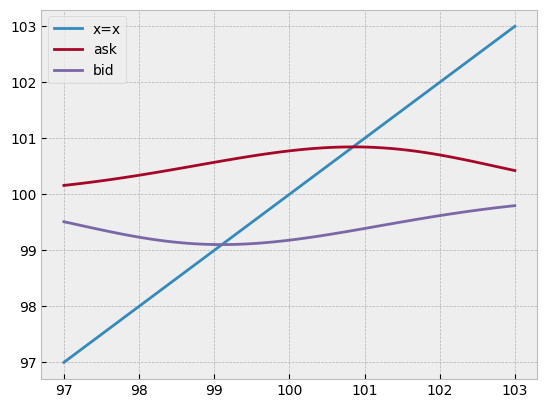

In [12]:
plt.plot(values, values, label="x=x")
plt.plot(values, Pas_fp, label="ask")
plt.plot(values, Pbs_fp, label="bid")
plt.legend()
plt.show()

Expected value function

In [23]:
def expected_value(Pb, Pa, psell, pbuy, vec_v, v_prior, alpha, eta, sigma_w):

    res = 0

    ## compute E[V | No order]
    for i, v in enumerate(vec_v):
        if v<Pb:
            res += v*v_prior[i]*((1-alpha)*(1-2*eta) + alpha*(1-norm.cdf(x=Pb-v, scale=sigma_w)))
        elif (Pb<=v) and (v<Pa):
            res += v*v_prior[i]*((1-alpha)*(1-2*eta) + alpha*(1-norm.cdf(x=Pb-v, scale=sigma_w) + norm.cdf(x=Pa-v, scale=sigma_w)))
        else:
            res += v*v_prior[i]*((1-alpha)*(1-2*eta) + alpha*norm.cdf(x=Pa-v, scale=sigma_w))

    ## add buy order and sell order parts
    res += Pb*psell + Pa*pbuy
    
    return res
        


Function to initiliaze the prior on V

Update of probability density on Vi


In [8]:
def init_vi_prior(sigma_price, multiplier, centered_at, only_probs:Optional[bool]=True, verbose:Optional[bool]=True):

    if verbose:
        print("lenght of prior vector: " + str(2*4*sigma_price*multiplier))


        if not isinstance(2*4*sigma_price*multiplier, int):
            warn("number of points not int --> converting it to int")

    vec_v = []
    prior_v = []
    for i in range(int(2*4*sigma_price*multiplier+1)):
        
        vec_v.append(centered_at-4*sigma_price+i/multiplier)
        prior_v.append(norm.cdf(x=-4*sigma_price+(i+1)/multiplier, scale=sigma_price) - norm.cdf(x=-4*sigma_price+i/multiplier, scale=sigma_price))

    assert np.abs(sum(prior_v)-1)<1e-4, "proba distr is not normalized"

    if only_probs:
        return prior_v
    else:
        return vec_v, prior_v

In [9]:
# def compute_posterior_vi(order_type, Pa, Pb, alpha, eta, sigma_w, vec_v:Optional[list], v_prior:Optional[list]):

#     prior_on_v = pd.DataFrame(data=[vec_v, v_prior]).T.rename(columns={0:"v", 1:"p"})

#     assert Pb < Pa, "ask price is below bid price"

#     if order_type == 1: #buy order
        
#         first_part = prior_on_v[prior_on_v.v <= Pa]
#         first_part["post"] = first_part.apply(lambda se: se["p"]*(1-(((1-alpha)*eta) + alpha*(1-norm.cdf(x=Pa-se["v"], scale=sigma_w)))), axis=1)
#         result = first_part["post"].to_list()
#         second_part = prior_on_v[prior_on_v.v > Pa]
#         second_part["post"] = second_part.apply(lambda se: se["p"]*((1-alpha)*eta + alpha*(1-norm.cdf(x=Pa-se["v"], scale=sigma_w))), axis=1)
#         result += second_part["post"].to_list()

#     elif order_type == -1: ## sell order

#         first_part = prior_on_v[prior_on_v.v <= Pb]
#         first_part["post"] = first_part.apply(lambda se: se["p"]*((1-alpha)*eta + alpha*norm.cdf(x=Pb-se["v"], scale=sigma_w)), axis=1)
#         result = first_part["post"].to_list()
#         second_part = prior_on_v[prior_on_v.v > Pb]
#         second_part["post"] = second_part.apply(lambda se: se["p"]*(1-(alpha*norm.cdf(x=Pb-se["v"], scale=sigma_w) + (1-alpha)*eta)), axis=1)
#         result += second_part["post"].to_list()

#     else:

#         first_part = prior_on_v[prior_on_v.v <= Pb]
#         first_part["post"] = first_part.apply(lambda se: se["p"]*(1-((1-alpha)*(1-2*eta) + alpha*(1-norm.cdf(x=Pb-se["v"], scale=sigma_w)))), axis=1)
#         result = first_part["post"].to_list()

#         second_part = prior_on_v[(prior_on_v.v > Pb) & (prior_on_v.v <= Pa)]
#         second_part["post"] = second_part.apply(lambda se: se["p"]*((1-alpha)*(1-2*eta) + alpha*(1-norm.cdf(x=Pb-se["v"], scale=sigma_w) + norm.cdf(x=Pa-se["v"], scale=sigma_w))), axis=1)
#         result += second_part["post"].to_list()

#         third_part = prior_on_v[prior_on_v.v > Pa]
#         third_part["post"] = third_part.apply(lambda se: se["p"]*(1-((1-alpha)*(1-2*eta) + alpha*norm.cdf(x=Pa-se["v"], scale=sigma_w))), axis=1)
#         result += third_part["post"].to_list()
        
#     ## rescale sum to one
#     result = list(np.array(result)/sum(result))

#     return result


In [10]:
def compute_posterior_vi(order_type, Pbuy, Psell, Pno, Pa, Pb, alpha, eta, sigma_w, vec_v:Optional[list], v_prior:Optional[list]):

    prior_on_v = pd.DataFrame(data=[vec_v, v_prior]).T.rename(columns={0:"v", 1:"p"})

    assert Pb < Pa, "ask price is below bid price"

    post = []

    if order_type == 1:

        for i, v in enumerate(vec_v):
            if v <= Pa:
                post.append(v_prior[i]*((1-alpha)*eta + alpha*(1-norm.cdf(x=Pa-v, scale=sigma_w))))
            else:
                post.append(v_prior[i]*(alpha*(1-norm.cdf(x=Pa-v, scale=sigma_w)) + (1-alpha)*eta))
        
        post = np.array(post)/Pbuy

    
    elif order_type == -1:

        for i, v in enumerate(vec_v):
            if v <= Pb:
                post.append(v_prior[i]*(alpha*norm.cdf(x=Pb-v, scale=sigma_w) + (1-alpha)*eta))
            else:
                post.append(v_prior[i]*(alpha*norm.cdf(x=Pb-v, scale=sigma_w) + (1-alpha)*eta))
        
        post = np.array(post)/Psell

    else:
        ## no order
        for i, v in enumerate(vec_v):
            if v < Pb:
                post.append(v_prior[i]*((1-alpha)*(1-2*eta) + alpha*(1-norm.cdf(x=Pb-v, scale=sigma_w))))
            elif (v>=Pb) and (v<Pa):
                post.append(v_prior[i]*((1-alpha)*(1-2*eta) + alpha*(1-norm.cdf(x=Pb-v, scale=sigma_w) + norm.cdf(x=Pa-v, scale=sigma_w))))
            else:
                post.append(v_prior[i]*((1-alpha)*(1-2*eta) + alpha*norm.cdf(x=Pa-v, scale=sigma_w)))

        post = np.array(post)/Pno

    assert np.abs(sum(post)-1)<1e-4, "proba distr is not normalized"

    return post


---

# Simulation:


In [24]:
##Parameters: 

alpha = 0.1 ## prop of informed traders
eta = 0.2 ## prop of buy/sell orders from u_traders
tmax = 300 ## duration of simulation

## true value
V0 = 100 ## initial price
sigma_price = 0.5
proba_jump = 0.01
val = asset_dynamics(p_jump=proba_jump, sigma=sigma_price, init_price=V0)
val.simulate(tmax = tmax)
jumps = val.dynamics["jumps"].to_list()
true_value = val.price(tmax = tmax).to_list()

## noisy informed traders
sigma_w = 0.05
nit_noise = np.random.normal(0, sigma_w, tmax)

## mm prior of true value distrib
## sigma_price already set above

##tracking of bid and ask
bids=[] ## will both have lenght tmax in the end
asks=[]
e_v_s=[]


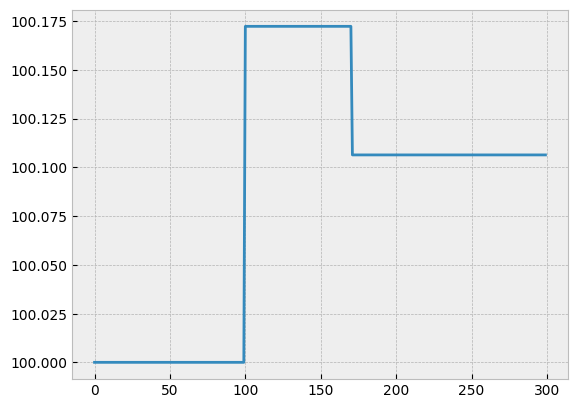

In [25]:
plt.plot(true_value)

Initialize prior on V

In [31]:
# the ampliture is 2*4*sigma_price in euros
## *100 to get in cents
multiplier = 50

vec_v, prior_v = init_vi_prior(sigma_price=sigma_price, multiplier=multiplier, centered_at=V0, only_probs=False)

prior_vs = [prior_v]

lenght of prior vector: 200.0


/var/folders/67/_r8h7_cd7jldth5h5vj1t1mh0000gn/T/ipykernel_21945/157719049.py:8: UserWarning: number of points not int --> converting it to int
  warn("number of points not int --> converting it to int")


In [39]:
P_no_order(Pa=asks[0], Pb=bids[0], alpha=alpha, eta=eta, sigma_w=0.05, vec_v=vec_v, v_prior=prior_vs[0])

0.5665567264791669

In [32]:
for t in range(tmax):
    
    print(t)
    if jumps[t] == 1:
        ## if jump ocurs, inform the MM by allowing him to re initialize its prior on V=Vi
        vec_v, prior_v = init_vi_prior(sigma_price=sigma_price, multiplier=multiplier, centered_at=V0, only_probs=False, verbose=False)
        prior_vs.append(prior_v)
    

    ## 1. bid, ask are set with the prior of the MM according to equations
    asks.append(fixed_point(Pa_fp, true_value[t], args=(alpha, eta, sigma_w, vec_v, prior_vs[-1]), xtol=1e-2, maxiter=500, method='del2').item())
    bids.append(fixed_point(Pb_fp, true_value[t], args=(alpha, eta, sigma_w, vec_v, prior_vs[-1]), xtol=1e-2, maxiter=500, method='del2').item())
    ## the second arg in the fixed point eq is the true value such that the FP sovler starts at the true value (it does not reveal it anywhere else)

    ## 2. store priors for posterior computation later on
    Pbuy = P_buy(Pa=asks[-1], alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=prior_vs[-1])
    Psell = P_sell(Pb=bids[-1], alpha=alpha, eta = eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=prior_vs[-1])
    Pnoorder = P_no_order(Pb=bids[-1], Pa=asks[-1], alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=prior_vs[-1])
    
    # compute extected value
    
    e_v_s.append(expected_value(Pb=bids[-1], Pa=asks[-1], psell=Psell, pbuy=Pbuy, vec_v=vec_v, v_prior=prior_vs[-1], alpha=alpha, eta=eta, sigma_w=sigma_w))

    ## 2. traders trade
    trader = np.random.choice(["NI", "U"], p=[alpha, 1-alpha])

    if trader == "U":
        trade = np.random.choice([1, -1, 0], p=[eta, eta, 1-2*eta]) #random trade by uninformed trader
    else:
        noisy_signal = true_value[t] + nit_noise[t]
        if noisy_signal > asks[t]:
            trade = 1           ## noisy trader buys
        elif noisy_signal < bids[t]:
            trade = -1          ## noisy trader sells
        else:
            trade = 0           ## noisy trader does nothing


    ## 3. Update of mm prob density
    ## needs to update the prior: posteior: because now the MM has new info (last trade)
    ## this will be the prior for the next period to set bid and asks
    
    #posterior_v = compute_posterior_vi(order_type=trade, Pa=asks[t], Pb=bids[t], alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=prior_vs[t])
    posterior_v = compute_posterior_vi(trade, Pbuy=Pbuy, Psell=Psell, Pno=Pnoorder, Pa=asks[-1], Pb=bids[-1], alpha=alpha, eta=eta, sigma_w=sigma_w, vec_v=vec_v, v_prior=prior_vs[-1])
    prior_vs.append(posterior_v)

        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

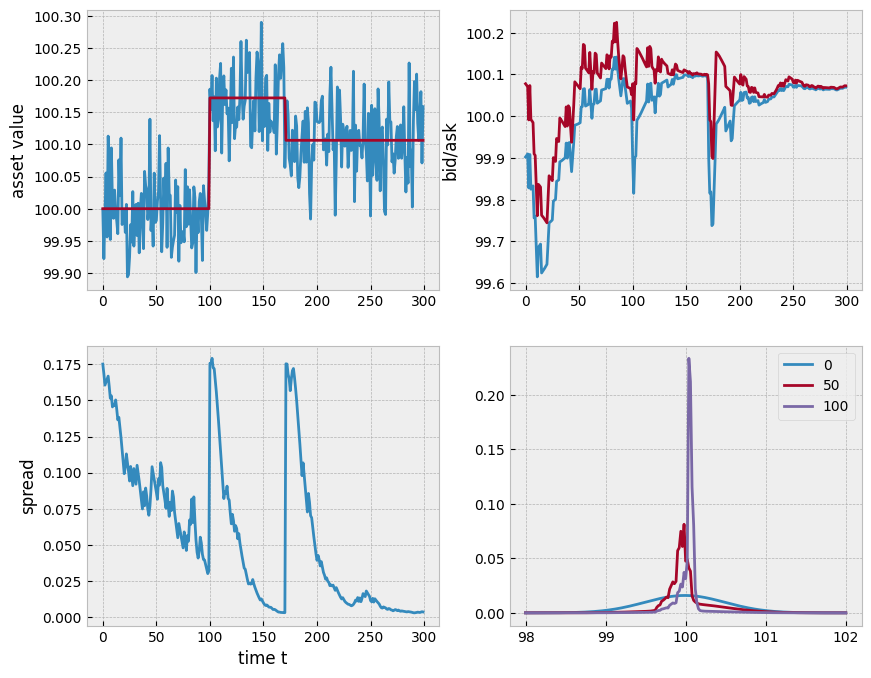

In [34]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
ax[0,0].plot([t for t in range(tmax)], [true_value[i] + nit_noise[i] for i in range(tmax)], label="noisy true value")
ax[0,0].plot([t for t in range(tmax)], true_value, label="true_val")
ax[0,0].set_ylabel("asset value")
#ax[0,0].plot([t for t in range(tmax)], [e_v_s[i] for i in range(tmax)], label="expected value")

ax[0, 1].plot([t for t in range(tmax)], bids, label="bid price")
ax[0, 1].plot([t for t in range(tmax)], asks, label="ask price")

ax[1,0].plot([t for t in range(tmax)], np.array(asks)-np.array(bids), label="spread")
ax[1,0].set_xlabel("time t")
ax[0,1].set_ylabel("bid/ask")
ax[1,0].set_ylabel("spread")

ax[1,1].plot(vec_v, prior_vs[0], label="0")
ax[1,1].plot(vec_v, prior_vs[50], label="50")
ax[1,1].plot(vec_v, prior_vs[100], label="100")
ax[1,1].legend()
plt.legend()
plt.show()